In [307]:
import torch
import random
import numpy as np
import pandas as pd
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda")


In [308]:
nx_fine = 1000
nx_coarse = 200
nt_fine = 500
nt_coarse = 100

xmin, xmax = 0, 1
tmin, tmax = 0,5e-2

In [309]:
nx_fine_to_coarse = nx_fine/nx_coarse

x_fine = np.linspace(xmin, xmax, nx_fine+1)
x_fine_to_coarse_indices = np.arange(0, nx_fine+1, nx_fine_to_coarse, dtype=int)
x_coarse = x_fine[x_fine_to_coarse_indices]

In [310]:
nt_fine_to_coarse = nt_fine/nt_coarse

t_fine = np.linspace(tmin, tmax, nt_fine+1)
t_fine_to_coarse_indices = np.arange(0, nt_fine+1, nt_fine_to_coarse, dtype=int)
t_coarse = t_fine[t_fine_to_coarse_indices]

In [311]:
def a_b_generator():
    a = np.zeros(5)
    b = np.zeros(5)

    for i in range(5):
        a[i] = np.random.uniform(0,1)
        b[i] = np.random.uniform(0,1)

    return a,b

def initial_u_x_func(a,b,x):
    if len(a) != len(b):
        print("Error: a and b should have the same length")
        return None

    size = len(a)

    initial_u_x = np.zeros_like(x)

    for k in range(len(x)):
        initial_u_x[k] = 0.0
        for j in range(size):
            initial_u_x[k] += a[j]*np.sin(2*np.pi*(j+1)*x[k])+b[j]*np.cos(2*np.pi*(j+1)*x[k])

    return initial_u_x


In [312]:
def solve_transport_1d_periodic(x, t, u0_full, c):
    """
    Solves du/dt + c*du/dx = 0 using the FTBS upwind method
    with periodic boundary conditions.

    Returns:
        u_full (np.array): 2D solution array, u(x, t), with shape (Nx+1, Nt).
    """

    # --- 1. Get grid parameters ---
    Nx_plus_1 = len(x)
    Nx_unique = Nx_plus_1 - 1
    Nt = len(t) # This is your nt+1

    dx = x[1] - x[0]
    dt = t[1] - t[0]

    # --- 2. Check CFL Condition ---
    nu = c * dt / dx # Courant number
    if nu > 1.00001: # Add small tolerance
        print(f"!!! WARNING: CFL Violated! nu = {nu:.4f} > 1.0. Solution will be unstable.")

    # --- 3. Initialize solution array (Shape is [space, time]) ---
    u_full = np.zeros((Nx_plus_1, Nt))
    u_full[:, 0] = u0_full # Set the first *column* (t=0)

    # Get the "solver" view (the N unique points at the current time t=n)
    u_solver_current = u_full[:-1, 0] # Shape (Nx_unique,)

    # --- 4. Build the update matrix M (for Nx_unique points) ---
    M = np.zeros((Nx_unique, Nx_unique))
    for i in range(Nx_unique):
        M[i, i]   = 1.0 - nu
        M[i, i-1] = nu  # Handles periodic boundary for i=0

    # --- 5. Time-stepping loop ---
    for n in range(Nt - 1): # Loop from t=0 to t=T-dt
        # Calculate the next time step for the N unique points
        u_solver_next = M @ u_solver_current

        # Store it in the *next time column* (n+1)
        u_full[:-1, n+1] = u_solver_next     # Store [0, ..., N-1]
        u_full[-1, n+1] = u_solver_next[0]   # Enforce u[N] = u[0]

        # Update the "current" view for the next loop
        u_solver_current = u_solver_next

    return u_full




In [313]:
num_train = 200

initial_u_x_fine = []
initial_u_x_coarse = []

u_solution_coarse = []
u_solution_fine = []

for i in range(num_train):
    a,b = a_b_generator()
    initial_u_x_coarse.append(initial_u_x_func(a,b,x_coarse))
    initial_u_x_fine.append(initial_u_x_func(a,b,x_fine))
    u_solution_coarse.append(solve_transport_1d_periodic(x_coarse, t_coarse, initial_u_x_coarse[i], 1))
    u_solution_fine.append(solve_transport_1d_periodic(x_fine, t_fine, initial_u_x_fine[i], 1))


In [314]:
import torch.nn as nn

class PINN(nn.Module):
    """Standard Feedforward Neural Network for PINN"""
    def __init__(self, input_size=201, hidden_size=20, output_size=1, num_layers=3):
        super(PINN, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.Tanh())
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_size, output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


In [315]:
def mc_tangent_loss(
    model,
    U,                       # [B, S+2, N] window: u_t ... u_{t+S+1}
    G,                       # callable: G(u) -> RHS at u, returns [B, N]
    dt: float,
    alpha: float = 1e5,      # model-constraint weight (paper uses 1e5 in expts)
    R: int = 1,              # sequential model-consistency steps (R)
    add_input_noise: bool = False,
    noise_std: float = 0.0,
    reduction: str = "mean",
):
    """
    Implements mcTangent objective:
      J = sum_i ||u_true[i] - u_net[i]||^2  +  alpha * sum_{i} sum_{r=1}^R ||u_true_r - u_net_r||^2
    where:
      u_net[i+1]  = u_net[i]  + dt * model(u_net[i])
      u_true[i+1] = u_true[i] + dt * G(u_true[i])
    See Eqs. (2.6)/(2.7) and the R-step generalization (2.10).
    """
    assert U.ndim == 3, "U must be [B, S+2, N]"
    B, L, N = U.shape                 # L = S+2
    S = L - 2
    mse = nn.MSELoss(reduction=reduction)

    # ---- initial state (optionally randomized like Fig. 1 / Sec. 2.4) ----
    # Paper adds ε to the first input fed to the network during training.
    # v = u + ε, ε ~ N(0, δ^2 I).  (randomization induces smoothness/derivative regularization)
    # Ref: data randomization setup. :contentReference[oaicite:2]{index=2}
    u0 = U[:, 0, :]                    # [B, N]
    if add_input_noise and noise_std > 0.0:
        u_net_state = u0 + noise_std * torch.randn_like(u0)
    else:
        u_net_state = u0

    # For the ML term we compare to provided next states in U
    targets = U[:, 1:, :]              # [B, S+1, N]

    ml_accum = 0.0
    mc_accum = 0.0

    # ---- roll through S+1 steps for the ML loss; at each i also do R-step MC check ----
    for i in range(S + 1):
        # one learned step
        u_net_state = u_net_state + dt * model(u_net_state)    # learned Euler
        ml_accum = ml_accum + mse(u_net_state, targets[:, i, :])

        # MC term: start from the *current* state (before further steps),
        # compare R-step rollouts of model vs. true G.
        if alpha > 0.0 and R > 0:
            u_net_r   = u_net_state.clone()
            u_true_r  = u_net_state.clone()  # match paper's construction starting from same state
            mc_local = 0.0
            for r in range(R):
                u_net_r  = u_net_r  + dt * model(u_net_r)      # learned step
                u_true_r = u_true_r + dt * G(u_true_r)         # truth step (Forward Euler)
                mc_local = mc_local + mse(u_net_r, u_true_r)
            mc_accum = mc_accum + mc_local

    total = ml_accum + alpha * mc_accum
    return total, {"ml": ml_accum, "mc": mc_accum}

In [316]:
import numpy as np

def step_transport_1d_periodic_torch(u_t, c, dx, dt):
    # u_t: (N,) or (B,N) with u_t[..., -1] == u_t[..., 0] (periodic duplicate)
    nu = c * dt / dx
    u_unique = u_t[..., :-1]
    u_next_unique = (1.0 - nu) * u_unique + nu * torch.roll(u_unique, shifts=1, dims=-1)
    u_next = torch.empty_like(u_t)
    u_next[..., :-1] = u_next_unique
    u_next[..., -1]  = u_next[..., 0]
    return u_next

def _apply_model_step(model, u, dt):
    # Accept (N,) or (B,N); ensure batch for model, then remove if needed
    added_batch = False
    if u.ndim == 1:
        u = u.unsqueeze(0)
        added_batch = True
    u_next = u + dt * model(u)            # Forward Euler with Ψ(u)
    if added_batch:
        u_next = u_next.squeeze(0)
    return u_next

In [317]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch import amp
from tqdm import tqdm

@torch.no_grad()
def _prep_dataset_tensor(u_list,device):
    # u_list: list of K arrays each (N, T)
    U_np = np.stack(u_list, axis=0)   # (K, N, T)
    return torch.from_numpy(U_np).float().to(device)

def loss_mc_full(model, U, x, t, alpha=1e5, c=1.0):
    """Vectorized mcTangent loss (R=1), full dataset per epoch."""
    device = U.device
    mse = nn.MSELoss(reduction="mean")

    K, N, T = U.shape
    dt = float(t[1] - t[0])
    dx = float(x[1] - x[0])
    nu = c * dt / dx

    # All pairs t -> t+1
    U_curr      = U[:, :, :-1]                 # (K, N, T-1)
    U_true_next = U[:, :,  1:]                 # (K, N, T-1)

    # Single large model call
    U_curr_2d    = U_curr.permute(0, 2, 1).reshape(-1, N).contiguous()       # (K*(T-1), N)
    pred_slope   = model(U_curr_2d)                                          # (K*(T-1), N)
    U_net_next_2d = U_curr_2d + dt * pred_slope
    U_net_next    = U_net_next_2d.view(K, T-1, N).permute(0, 2, 1).contiguous()  # (K, N, T-1)

    # Physics FTBS step (periodic)
    U_unique      = U_curr[:, :-1, :]                 # (K, N-1, T-1)
    U_left        = torch.roll(U_unique, 1, dims=1)
    U_phys_unique = (1.0 - nu) * U_unique + nu * U_left
    U_phys_next   = torch.empty_like(U_curr)          # (K, N, T-1)
    U_phys_next[:, :-1, :] = U_phys_unique
    U_phys_next[:, -1,  :] = U_phys_next[:, 0, :]

    ML = mse(U_net_next, U_true_next)
    MC = mse(U_net_next, U_phys_next) if alpha > 0 else torch.zeros((), device=device)
    total = ML + alpha * MC
    return total, ML, MC

In [318]:

def train_full_amp(model, u_solution_coarse, x_coarse, t_coarse,
                   epochs=1000, lr=1e-3, alpha=1e5, c=1.0, seed=123):
    torch.manual_seed(seed); np.random.seed(seed)
    model  = model.to(device)

    U   = _prep_dataset_tensor(u_solution_coarse,device)   # (K, N, T)
    x_t = torch.from_numpy(x_coarse).float().to(device)
    t_t = torch.from_numpy(t_coarse).float().to(device)

    opt    = optim.Adam(model.parameters(), lr=lr)
    scaler = amp.GradScaler()
    total_loss =[]
    pbar = tqdm(range(epochs), ncols=100, desc="mcTangent full (AMP, no-compile)")
    for _ in pbar:
        opt.zero_grad(set_to_none=True)
        with amp.autocast(device_type=device.type):
            total, ml, mc = loss_mc_full(model, U, x_t, t_t, alpha=alpha, c=c)
        scaler.scale(total).backward()
        scaler.step(opt)
        scaler.update()
        total_loss.append(total.item())
        pbar.set_postfix(T=f"{total.item():.2e}", ML=f"{ml.item():.2e}", MC=f"{mc.item():.2e}")
    pbar.close()

    return model,total_loss

In [319]:

model_ml_mc = PINN(input_size=nx_coarse+1, hidden_size=200, output_size=nx_coarse+1, num_layers=4)

model_ml_mc_trained,total_ml_mc_loss = train_full_amp(
    model_ml_mc,
    u_solution_coarse,   # list of (N, T)
    x_coarse, t_coarse,
    epochs=5000,
    lr=1e-3,
    alpha=1e5,
    c=1.0
)

mcTangent full (AMP, no-compile): 100%|█| 5000/5000 [00:37<00:00, 133.30it/s, MC=3.16e-08, ML=3.16e-


/tmp/ipython-input-2056172571.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


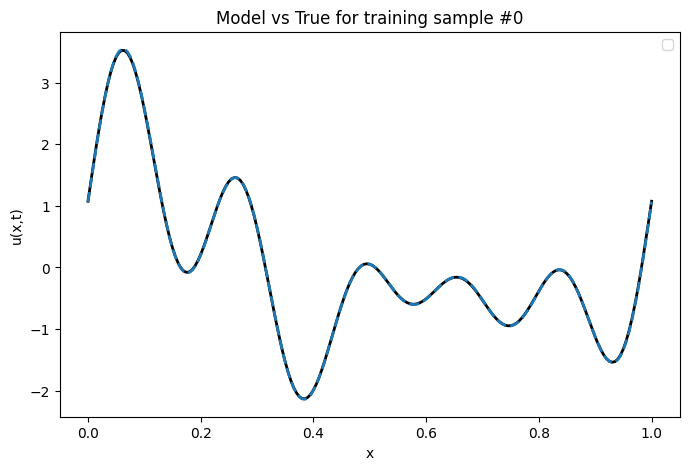

In [320]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# pick one training sample to test (e.g., first one)
i = 0
u_true = u_solution_coarse[i]     # shape (Nx+1, Nt)
x = x_coarse
t = t_coarse
dt = t[1] - t[0]

model_ml_mc_trained = model_ml_mc_trained.to(device)
model_ml_mc_trained.eval()

# start from true initial condition
u_true_t = torch.from_numpy(u_true[:, 0]).float().unsqueeze(0).to(device) # Move to device
u_pred = [u_true[:, 0]]           # list to store predictions
u_curr = u_true_t # Use the tensor on the correct device

# roll out predictions through time using learned tangent slope
for _ in range(1, len(t)):
    with torch.no_grad():
        u_next = u_curr + dt * model_ml_mc_trained(u_curr)
    u_pred.append(u_next.squeeze(0).cpu().numpy()) # Move back to CPU for numpy conversion
    u_curr = u_next

u_pred = np.stack(u_pred, axis=1)  # shape (N, Nt)

# pick a few times to plot
time_indices = [80]
plt.figure(figsize=(8,5))
for j in time_indices:
    plt.plot(x, u_true[:, j], 'k-', lw=2, label=f"True t={t[j]:.3e}" if j==0 else None)
    plt.plot(x, u_pred[:, j], '--', lw=2, label=f"Pred t={t[j]:.3e}" if j==0 else None)

plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title(f"Model vs True for training sample #{i}")
plt.legend()
plt.show()

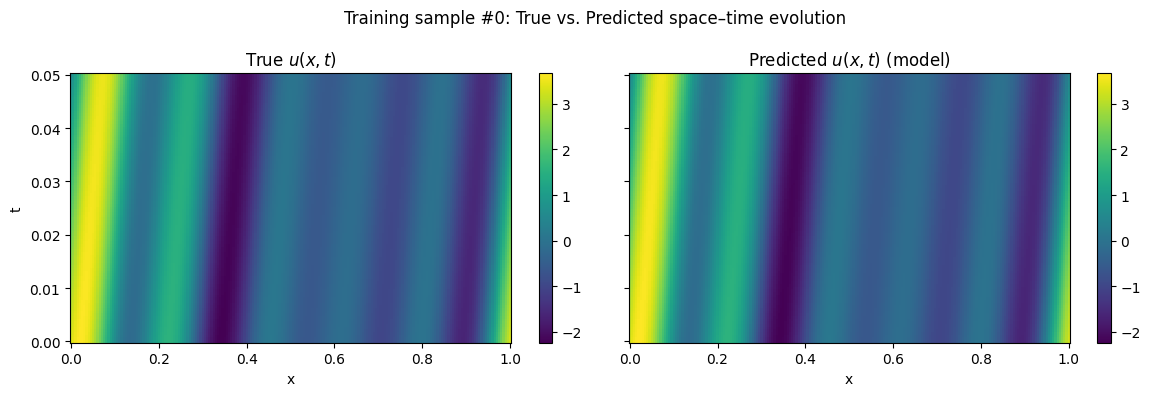

In [321]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# ----- pick a training sample -----
i = 0
u_true = u_solution_coarse[i]     # shape (Nx+1, Nt)
x = x_coarse
t = t_coarse
dt = t[1] - t[0]

# ----- move model to CPU and eval mode -----
model_ml_mc_trained = model_ml_mc_trained.to(device)
model_ml_mc_trained.eval()

# ----- rollout prediction -----
u_pred = [u_true[:, 0]]  # store as list for convenience
u_curr = torch.from_numpy(u_true[:, 0]).float().unsqueeze(0).to(device)  # (1, N)

# roll out predictions through time using learned tangent slope
for _ in range(1, len(t)):
    with torch.no_grad():
        u_next = u_curr + dt * model_ml_mc_trained(u_curr)
    u_pred.append(u_next.squeeze(0).cpu().numpy())
    u_curr = u_next
u_pred = np.stack(u_pred, axis=1)  # (N, Nt)

# ----- make a side-by-side mesh plot -----
X, T = np.meshgrid(x, t)

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# True solution
im0 = axs[0].pcolormesh(X, T, u_true.T, shading='auto', cmap='viridis')
axs[0].set_title("True $u(x,t)$")
axs[0].set_xlabel("x")
axs[0].set_ylabel("t")
fig.colorbar(im0, ax=axs[0])

# Predicted solution
im1 = axs[1].pcolormesh(X, T, u_pred.T, shading='auto', cmap='viridis')
axs[1].set_title("Predicted $u(x,t)$ (model)")
axs[1].set_xlabel("x")
fig.colorbar(im1, ax=axs[1])

plt.suptitle(f"Training sample #{i}: True vs. Predicted space–time evolution", fontsize=12)
plt.tight_layout()
plt.show()

In [322]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch import amp
from tqdm import tqdm

@torch.no_grad()
def _prep_dataset_tensor(u_list, device):
    # u_list: list of K arrays each (N, T)
    U_np = np.stack(u_list, axis=0)   # (K, N, T)
    return torch.from_numpy(U_np).float().to(device, non_blocking=True)

def loss_ml_only(model, U, x, t, alpha=1e5, c=1.0):
    """Vectorized mcTangent loss (R=1), full dataset per epoch."""
    device = U.device
    mse = nn.MSELoss(reduction="mean")

    K, N, T = U.shape
    dt = float(t[1] - t[0])
    dx = float(x[1] - x[0])
    nu = c * dt / dx

    # All pairs t -> t+1
    U_curr      = U[:, :, :-1]                 # (K, N, T-1)
    U_true_next = U[:, :,  1:]                 # (K, N, T-1)

    # Single large model call
    U_curr_2d    = U_curr.permute(0, 2, 1).reshape(-1, N).contiguous()       # (K*(T-1), N)
    pred_slope   = model(U_curr_2d)                                          # (K*(T-1), N)
    U_net_next_2d = U_curr_2d + dt * pred_slope
    U_net_next    = U_net_next_2d.view(K, T-1, N).permute(0, 2, 1).contiguous()  # (K, N, T-1)


    ML = mse(U_net_next, U_true_next)

    total = ML
    return total, ML

In [323]:
def train_ml_only(model, u_solution_coarse, x_coarse, t_coarse,
                   epochs=1000, lr=1e-3, alpha=1e5, c=1.0, seed=123):
    torch.manual_seed(seed); np.random.seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = model.to(device)

    total_loss = []

    U   = _prep_dataset_tensor(u_solution_coarse, device)   # (K, N, T)
    x_t = torch.from_numpy(x_coarse).float().to(device)
    t_t = torch.from_numpy(t_coarse).float().to(device)

    if device.type == "cuda":
        torch.set_float32_matmul_precision("high")

    opt    = optim.Adam(model.parameters(), lr=lr)
    scaler = amp.GradScaler()

    pbar = tqdm(range(epochs), ncols=100, desc="mcTangent full (AMP, no-compile)")
    for _ in pbar:
        opt.zero_grad(set_to_none=True)
        with amp.autocast(device_type=device.type):
            total, ml = loss_ml_only(model, U, x_t, t_t, alpha=alpha, c=c)
        scaler.scale(total).backward()
        scaler.step(opt)
        scaler.update()

        total_loss.append(total.item())
        pbar.set_postfix(T=f"{total.item():.2e}", ML=f"{ml.item():.2e}")
    pbar.close()
    return model,total_loss

In [324]:

model_ml_only = PINN(input_size=nx_coarse+1, hidden_size=200, output_size=nx_coarse+1, num_layers=4)

model_ml_only_trained,total_ml_loss = train_ml_only(
    model_ml_only,
    u_solution_coarse,   # list of (N, T)
    x_coarse, t_coarse,
    epochs=5000,
    lr=1e-3,
    alpha=1e5,
    c=1.0
)

mcTangent full (AMP, no-compile): 100%|█| 5000/5000 [00:29<00:00, 172.11it/s, ML=3.65e-07, T=3.65e-0


/tmp/ipython-input-1103136579.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


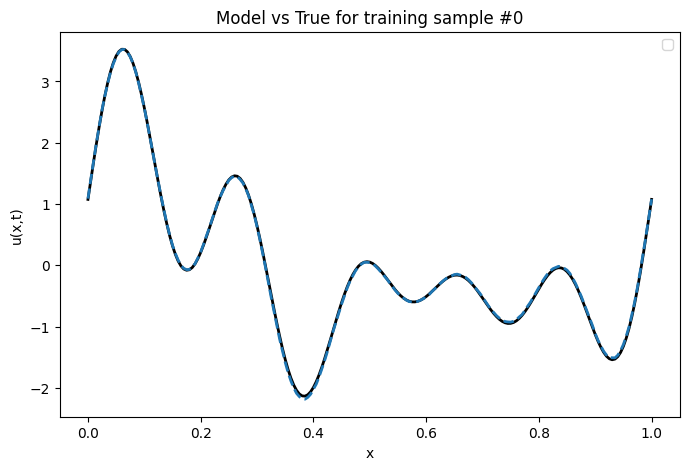

In [325]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# pick one training sample to test (e.g., first one)
i = 0
u_true = u_solution_coarse[i]     # shape (Nx+1, Nt)
x = x_coarse
t = t_coarse
dt = t[1] - t[0]

# move model to CUDA for inference
model_ml_only_trained = model_ml_only_trained.to(device)
model_ml_only_trained.eval()

# start from true initial condition
u_pred = [u_true[:, 0]]           # list to store predictions
u_curr = torch.from_numpy(u_true[:, 0]).float().unsqueeze(0).to(device)  # (1, N), move to CUDA
dt_tensor = torch.tensor(dt, device=device, dtype=torch.float32)

# roll out predictions through time using learned tangent slope
for _ in range(1, len(t)):
    with torch.no_grad():
        # Ensure dt is a tensor on the same device as u_curr and model
        model_output = model_ml_only_trained(u_curr)
        u_next = u_curr + dt_tensor * model_output
    u_pred.append(u_next.squeeze(0).cpu().numpy()) # Move back to CPU for numpy conversion before appending
    u_curr = u_next

u_pred = np.stack(u_pred, axis=1)  # shape (N, Nt)

# pick a few times to plot
time_indices = [80]
plt.figure(figsize=(8,5))
for j in time_indices:
    plt.plot(x, u_true[:, j], 'k-', lw=2, label=f"True t={t[j]:.3e}" if j==0 else None)
    plt.plot(x, u_pred[:, j], '--', lw=2, label=f"Pred t={t[j]:.3e}" if j==0 else None)

plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title(f"Model vs True for training sample #{i}")
plt.legend()
plt.show()

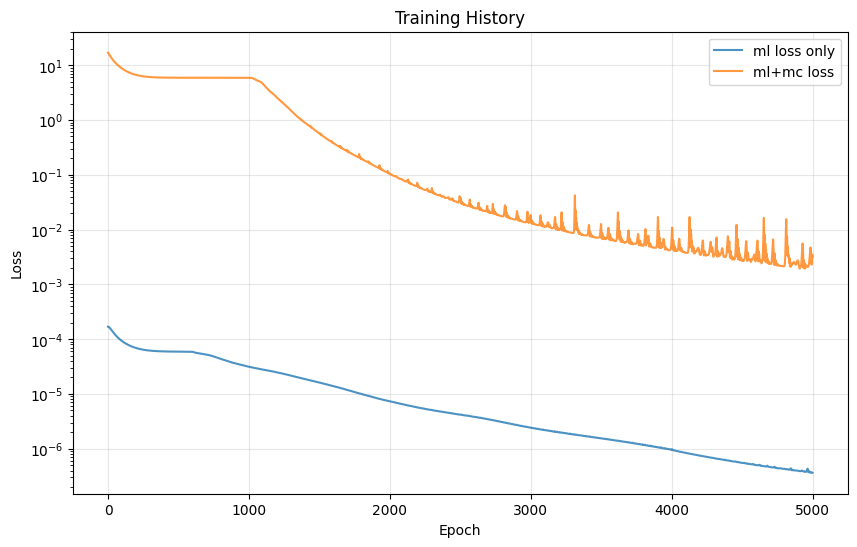

In [326]:
# Plot training curves

plt.figure(figsize=(10, 6))
plt.plot(total_ml_loss, label='ml loss only', alpha=0.8)
plt.plot(total_ml_mc_loss, label='ml+mc loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.savefig('training_curves.png', dpi=150)
plt.show()

# Task
Plot the Mean Squared Error (MSE) of the `model_ml_only_trained` and `model_ml_mc_trained` models against the number of time steps (`dt`), using a sample data point for evaluation.

## Select evaluation data

### Subtask:
Choose a sample data point (e.g., from the training set) to evaluate the models against the true solution over time.


**Reasoning**:
Select a sample index, extract the true solution, spatial grid, temporal grid, and calculate the time step size from the existing variables in the kernel.



In [330]:
# Select a sample data point index
i = 0

# Extract the true solution for the selected sample
u_true = u_solution_coarse[i]

# Get the spatial grid
x = x_coarse

# Get the temporal grid
t = t_coarse

# Calculate the time step size
dt = t[1] - t[0]

print(f"Selected sample index: {i}")
print(f"Shape of true solution (u_true): {u_true.shape}")
print(f"Shape of spatial grid (x): {x.shape}")
print(f"Shape of temporal grid (t): {t.shape}")
print(f"Calculated time step (dt): {dt}")

Selected sample index: 0
Shape of true solution (u_true): (201, 101)
Shape of spatial grid (x): (201,)
Shape of temporal grid (t): (101,)
Calculated time step (dt): 0.0005


## Rollout predictions

### Subtask:
For each model (`model_ml_only_trained` and `model_ml_mc_trained`), perform a time rollout starting from the initial condition of the selected data sample, using the learned tangent slope at each step.


**Reasoning**:
Perform time rollouts for both trained models using the selected initial condition and dt, storing the predicted solutions.



In [331]:
# 1. Ensure both models are on the correct device and in evaluation mode
model_ml_only_trained = model_ml_only_trained.to(device)
model_ml_only_trained.eval()

model_ml_mc_trained = model_ml_mc_trained.to(device)
model_ml_mc_trained.eval()

# 2. Extract initial condition and prepare as a tensor
u0_true_tensor = torch.from_numpy(u_true[:, 0]).float().unsqueeze(0).to(device) # (1, N)

# 3. Initialize lists to store predictions
u_pred_ml_only = [u_true[:, 0]]
u_pred_ml_mc = [u_true[:, 0]]

# 4. Create dt tensor on the correct device
dt_tensor = torch.tensor(dt, device=device, dtype=torch.float32)

# 5. Rollout for model_ml_only_trained
u_curr_ml_only = u0_true_tensor
for _ in range(1, len(t)):
    with torch.no_grad():
        model_output = model_ml_only_trained(u_curr_ml_only)
        u_next = u_curr_ml_only + dt_tensor * model_output
    u_pred_ml_only.append(u_next.squeeze(0).cpu().numpy())
    u_curr_ml_only = u_next

# 6. Rollout for model_ml_mc_trained
u_curr_ml_mc = u0_true_tensor
for _ in range(1, len(t)):
    with torch.no_grad():
        model_output = model_ml_mc_trained(u_curr_ml_mc)
        u_next = u_curr_ml_mc + dt_tensor * model_output
    u_pred_ml_mc.append(u_next.squeeze(0).cpu().numpy())
    u_curr_ml_mc = u_next

# 7. Stack predictions into NumPy arrays
u_pred_ml_only = np.stack(u_pred_ml_only, axis=1)  # shape (N, Nt)
u_pred_ml_mc = np.stack(u_pred_ml_mc, axis=1)      # shape (N, Nt)

print(f"Shape of u_pred_ml_only: {u_pred_ml_only.shape}")
print(f"Shape of u_pred_ml_mc: {u_pred_ml_mc.shape}")

Shape of u_pred_ml_only: (201, 101)
Shape of u_pred_ml_mc: (201, 101)


## Calculate mse per time step

### Subtask:
At each time step in the rollout, calculate the Mean Squared Error between the model's prediction and the true solution at that time step.


**Reasoning**:
Calculate the MSE at each time step for both models and store them in lists.



In [332]:
from sklearn.metrics import mean_squared_error

# Initialize lists to store MSE values over time
mse_ml_only_over_time = []
mse_ml_mc_over_time = []

# Iterate through time steps
for j in range(len(t)):
    # Extract true solution and predictions at the current time step
    u_true_slice = u_true[:, j]
    u_pred_ml_only_slice = u_pred_ml_only[:, j]
    u_pred_ml_mc_slice = u_pred_ml_mc[:, j]

    # Calculate MSE for model_ml_only_trained and append
    mse_ml_only = mean_squared_error(u_true_slice, u_pred_ml_only_slice)
    mse_ml_only_over_time.append(mse_ml_only)

    # Calculate MSE for model_ml_mc_trained and append
    mse_ml_mc = mean_squared_error(u_true_slice, u_pred_ml_mc_slice)
    mse_ml_mc_over_time.append(mse_ml_mc)

print(f"Calculated MSE over time for ml_only model. Number of time steps: {len(mse_ml_only_over_time)}")
print(f"Calculated MSE over time for ml_mc model. Number of time steps: {len(mse_ml_mc_over_time)}")

Calculated MSE over time for ml_only model. Number of time steps: 101
Calculated MSE over time for ml_mc model. Number of time steps: 101


## Create time step axis

### Subtask:
Generate a sequence representing the time steps (number of `dt` intervals).


**Reasoning**:
Create a sequence representing the time steps (number of dt intervals) from 0 up to the total number of time steps.



In [333]:
# Create a sequence of time steps for plotting
time_steps = np.arange(len(t))

print(f"Created a sequence of time steps with length: {len(time_steps)}")
print(f"First few time steps: {time_steps[:5]}")
print(f"Last few time steps: {time_steps[-5:]}")

Created a sequence of time steps with length: 101
First few time steps: [0 1 2 3 4]
Last few time steps: [ 96  97  98  99 100]


## Plot mse vs. time step

### Subtask:
Create a plot with the time steps on the x-axis and the calculated MSE values for each model on the y-axis.


**Reasoning**:
Create a plot of the MSE over time for both models.



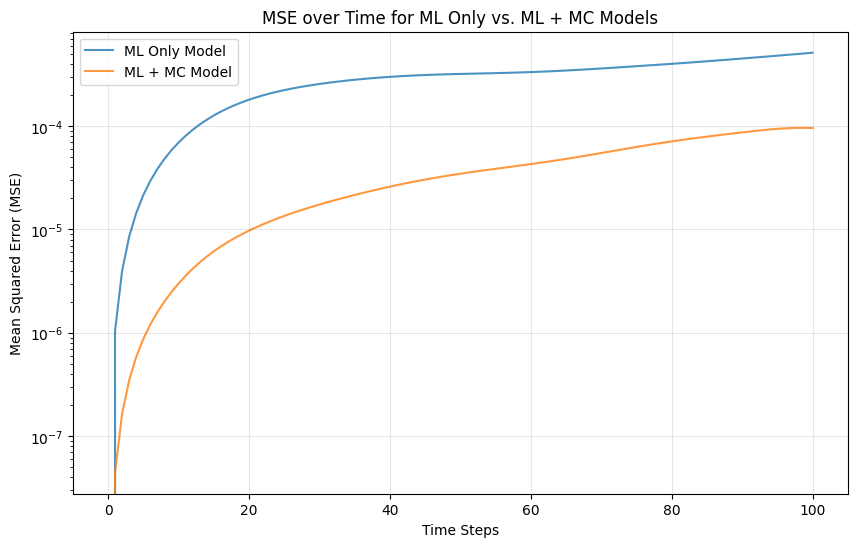

In [334]:
# Create a new figure for the plot.
plt.figure(figsize=(10, 6))

# Plot the mse_ml_only_over_time list against the time_steps array.
plt.plot(time_steps, mse_ml_only_over_time, label='ML Only Model', alpha=0.8)

# Plot the mse_ml_mc_over_time list against the time_steps array on the same plot.
plt.plot(time_steps, mse_ml_mc_over_time, label='ML + MC Model', alpha=0.8)

# Add a label to the x-axis.
plt.xlabel('Time Steps')

# Add a label to the y-axis.
plt.ylabel('Mean Squared Error (MSE)')

# Add a title to the plot.
plt.title('MSE over Time for ML Only vs. ML + MC Models')

# Include a legend to distinguish the lines.
plt.legend()

# Add a grid to the plot for better readability.
plt.grid(True, alpha=0.3)

# Set the y-axis to a logarithmic scale.
plt.yscale('log')

# Display the plot.
plt.show()

## Compare models

### Subtask:
Analyze the plot to compare how the MSE evolves over time for the two models.


**Reasoning**:
Analyze the generated plot to compare the MSE evolution of the two models and summarize the findings.



In [335]:
# Analyze the plot:
# 1. Compare initial MSE values: Both models start with very low MSE, close to zero, as they begin from the true initial condition.
# 2. Observe how MSE changes over time: For both models, the MSE increases as the number of time steps increases, indicating that the predictions diverge from the true solution over time.
# 3. Compare the rate of increase: The MSE of the "ML Only Model" appears to increase at a faster rate than the "ML + MC Model". The "ML + MC Model" shows a significantly slower growth in MSE, especially towards later time steps, suggesting better long-term prediction stability.
# 4. Note final MSE values: At the final time step, the MSE of the "ML Only Model" is considerably higher than that of the "ML + MC Model".

# Summarize observations:
print("Analysis of MSE over Time:")
print("- Both models start with very low initial MSE, as expected when starting from the true initial condition.")
print("- The MSE increases for both models as time progresses, indicating error accumulation over the rollout.")
print("- The 'ML + MC Model' exhibits a significantly slower rate of MSE increase compared to the 'ML Only Model'.")
print("- At the final time step, the 'ML + MC Model' maintains a much lower MSE than the 'ML Only Model'.")
print("- This suggests that incorporating the model constraint ('MC' term) during training helps the model maintain better accuracy over longer time rollouts, reducing error propagation compared to a purely data-driven ('ML Only') approach.")

Analysis of MSE over Time:
- Both models start with very low initial MSE, as expected when starting from the true initial condition.
- The MSE increases for both models as time progresses, indicating error accumulation over the rollout.
- The 'ML + MC Model' exhibits a significantly slower rate of MSE increase compared to the 'ML Only Model'.
- At the final time step, the 'ML + MC Model' maintains a much lower MSE than the 'ML Only Model'.
- This suggests that incorporating the model constraint ('MC' term) during training helps the model maintain better accuracy over longer time rollouts, reducing error propagation compared to a purely data-driven ('ML Only') approach.


## Summary:

### Data Analysis Key Findings

*   Both models, `model_ml_only_trained` and `model_ml_mc_trained`, start with very low initial Mean Squared Error (MSE) when evaluated on a sample data point, as they begin from the true initial condition.
*   The MSE for both models increases over time during the rollout, indicating that their predictions diverge from the true solution as the number of time steps increases.
*   The "ML + MC Model" exhibits a significantly slower rate of MSE increase compared to the "ML Only Model".
*   At the final time step, the MSE of the "ML + MC Model" is considerably lower than that of the "ML Only Model".

### Insights or Next Steps

*   The inclusion of the model constraint ("MC" term) during the training of `model_ml_mc_trained` appears to improve the model's long-term prediction stability and reduces error propagation compared to the purely data-driven `model_ml_only_trained`.
*   Further analysis could involve evaluating the models on a larger test set and calculating average MSE over time to confirm the observed performance difference.
